# Banc Statique <br>
### STAGE ANCHES <br>
Camille Urban <br>
19/08/2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import cv2
import os
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# des beaux graphiques
import seaborn as sns

from fonctions_BS import *


In [3]:
%matplotlib
%matplotlib

Using matplotlib backend: <object object at 0x000001D0ECCC3680>
Using matplotlib backend: TkAgg


# LOAD DATA

In [4]:
# # datas du 30/05/2024
# Une anche de force 3 1/2 mesurée avec 13*21pt, 40min

# SENSIBILITE CAPTEUR
# # S_force_bs =       # bs pour banc statique, sensibilité en N/mV
# G_force_bs = 900        # gain du banc de mesure
# S_camera = 98  # pix/mm
# dossier = '2024.05.30'
# imag = '/image_'
# seuil = 120

# # LOAD DATAs
# nbre_anche = 1

# # load data
# data = pd.read_table(dossier + '/data_anche1.txt', sep=' ', header=1).values # contient : [y, z, offset, moyenne_brute, moyenne(N) en grandeur physique]
# position_y = data[:,0]
# position_z = data[:,1]
# forces = data[:,4]

In [5]:
# SENSIBILITE CAPTEUR
S_force_bs = 0.04026/100      # bs pour banc statique, sensibilité en N/mV
G_force_bs = 900        # gain du banc de mesure
S_camera = 98  # pix/mm

dossier = 'mesures_BS_2024.10.16'
imag = '/image_'
seuil = 120

# LOAD DATAs
nbre_anche = 5

# load data
# data = pd.read_table(dossier + '/data_anche1.txt', sep=' ', header=0).values # contient : [force_anche distance_pointe_anche y z moyenne_brute moyenne(N)] 
data = np.genfromtxt(dossier + '/data_anche1.txt', delimiter=' ', skip_header=2)
position_y = data[:,2]
position_z = data[:,3]
forces = data[:,5]

    Erreur quadratique moyenne (MSE) : mesure l'erreur entre des valeurs mesurées et le modèle, évalue la précision d'un modèle 
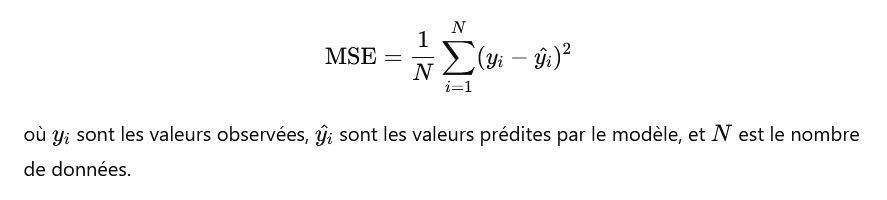

    Déviation standard - Standard Deviation (STD) : mesure la dispersion des valeurs d'une variable autour de la moyenne, caractérise la distribution d'un ensemble de données
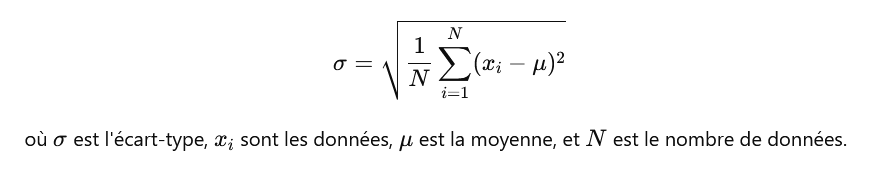

    Loi de student

In [6]:
# Profils de raideurs 

plt.close('all')

# with open(f'2024.05.30/data_BS_force.txt', 'w') as file:pos_y = np.linspace(start, end, num=100)
with open(dossier + f'/data_BS_force.txt', 'w') as file:
    file.write(f'Num_Anche K0 K1 x0 K00 K01 x00 \n')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    coef_as =[]
    coef_bs = []
    coef_raideurs = []
    coef_origines = []
    for i in range (nbre_anche):
        data = np.genfromtxt(dossier + f'/data_anche{i+1}.txt', delimiter=' ', skip_header=2)
        position_y = data[:,2]
        position_z = data[:,3]
        forces = data[:,5]
        coef_raideur, coef_origine, _, pos_y, coef_a, coef_b = modelisation_profile_de_raideur(position_y, position_z, forces, numero_anche=f'{i+1}', profil_only=False, pentes_et_profils=True)
        linspace_posy = np.linspace(pos_y[0], pos_y[-1], num=100)
        coef_as.append(coef_a)
        coef_bs.append(coef_b)
        coef_raideurs.append(coef_raideur)
        coef_origines.append(coef_origine)
        file.write(f'Anche_{i} {coef_raideur[0]} {coef_raideur[1]} {coef_raideur[2]} {coef_origine[0]} {coef_origine[1]} {coef_origine[2]} \n')
        # print(coef_raideur, coef_origine)
        ax1.plot(linspace_posy, np.polyval(coef_a, linspace_posy), color=(0.1, 0.3 + 0.15 * i, 0.8 - 0.1 * i),  linestyle='-', lw='1', label=f'rep{i+1}')
        ax2.plot(linspace_posy, np.polyval(coef_b, linspace_posy), color=(0.1, 0.3 + 0.15 * i, 0.8 - 0.1 * i),  linestyle='-', lw='1', label=f'rep{i+1}')
     
    # a pour la raideur
    # b pour l'ordonnée à l'origine    
    # moyennes et erreurs
    mean_a = np.mean(coef_as, axis=0)
    MSE_a = np.sqrt(np.mean((coef_as - mean_a)**2, axis=0)) # erreur quadratique moyenne 
    sigma_a = np.std(coef_as, axis=0) # STD
    N_lib = 5-1 # degré de liberté dans la loi de student = nbre_repetition -1
    tau_confiance = 0.95 # on choisit d'avoir un taux de confiance de 95%
    t_student = 2.78
    
    mean_b = np.mean(coef_bs, axis=0)
    MSE_b = np.sqrt(np.mean((coef_bs - mean_b)**2, axis=0))
    sigma_a = np.std(coef_as, axis=0)
    
    ax1.plot(linspace_posy, np.polyval(mean_a, linspace_posy), 'red',  linestyle='--', lw='2', label=f'moyenne')
    ax1.plot(linspace_posy, np.polyval(mean_a+MSE_a, linspace_posy), 'orange',  linestyle='--', lw='1', label=f'erreurs')
    ax1.plot(linspace_posy, np.polyval(mean_a-MSE_a,linspace_posy), 'orange',  linestyle='--', lw='1')
    ax2.plot(linspace_posy, np.polyval(mean_b, linspace_posy), 'red',  linestyle='--', lw='2', label=f'moyenne')
    ax2.plot(linspace_posy, np.polyval(mean_b+MSE_b, linspace_posy), 'orange',  linestyle='--', lw='1', label=f'erreurs')
    ax2.plot(linspace_posy, np.polyval(mean_b-MSE_b, linspace_posy), 'orange',  linestyle='--', lw='1')
    
    ax1.set_title('Profil de raideur', fontsize=16)
    ax1.set_xlabel('Coordonnée y (mm)', fontsize=14)
    ax1.set_ylabel('Force (N)', fontsize=14)
    ax1.grid()
    ax1.legend()
    ax2.set_title('Profil d\'ordonnées \à l\'origine', fontsize=16)
    ax2.set_xlabel('Coordonnée y (mm)', fontsize=14)
    ax2.set_ylabel('Force (N)', fontsize=14)
    ax2.grid()
    ax2.legend()

In [31]:
# faire un moyenne par colonne - polynome 2nd deg : ax2 + bx + c
# plt.close('all')
# Moyennes et erreurs
mean_a = np.mean(coef_as, axis=0)
# errors_a = np.sqrt(np.mean((coef_as - mean_a)**2, axis=0)) # erreur quadratique moyenne 
errors_a = np.std(coef_as, axis=0)
errors_a_percent = (errors_a / np.abs(mean_a)) * 100
mean_b = np.mean(coef_bs, axis=0)
# errors_b = np.sqrt(np.mean((coef_bs - mean_b)**2, axis=0))
errors_b = np.std(coef_bs, axis=0)
errors_b_percent = (errors_b / np.abs(mean_b)) * 100

# print(mean_a, errors_a, errors_a_percent)
print(mean_b, errors_b, errors_b_percent)

[-0.03563474  0.00619902  1.9289785 ] [0.00045129 0.00193037 0.00833989] [ 1.26644392 31.13996508  0.43234773]
[ 0.00188184 -0.01763605 -0.130491  ] [0.00032733 0.0011912  0.00685182] [17.39420337  6.75432962  5.2508028 ]


In [32]:
# faire un moyenne par colonne - polynome 2nd deg : K0-K1+(x-x0)²

# plt.close('all')
# Moyennes et erreurs
mean_raideur = np.mean(coef_raideurs, axis=0)
# errors_raideur = np.sqrt(np.mean((coef_raideurs - mean_raideur)**2, axis=0)) # erreur quadratique moyenne 
errors_raideur = np.std(coef_raideurs, axis=0)
errors_raideur_percent = (errors_raideur / np.abs(mean_raideur)) * 100
mean_origine = np.mean(coef_origines, axis=0)
errors_origine = np.sqrt(np.mean((coef_origines - mean_origine)**2, axis=0))
errors_origine_percent = (errors_origine / np.abs(mean_origine)) * 100

print(mean_raideur, errors_raideur, errors_raideur_percent)
# print(mean_origine, errors_origine, errors_origine_percent)


[ 1.92896796 -0.03563474 -0.08688929] [0.00834236 0.00045129 0.02707664] [ 0.43247792  1.26644392 31.162231  ]


In [39]:
y0s = np.array([13.5013065, 13.483209, 13.4845425, 13.517498999999999, 13.539978])
mean_y0s = np.mean(y0s)
error_y0s = np.std(y0s)
# error_y0s = np.sqrt(np.mean((y0s - mean_y0s)**2))
errors_y0s_percent = (error_y0s / np.abs(mean_y0s)) * 100
print(mean_y0s, error_y0s, errors_y0s_percent)

13.505307000000002 0.02138323254094168 0.1583320730209367


## Image

In [40]:
plt.close('all')
seuil = 120
S_camera = 98  # pix/mm
# Initialisation sur une image

# data_pos = pd.read_table(dossier + '/data_anche1.txt', sep=' ', header=1).values # contient : [y, z, offset, moyenne_brute, moyenne(N) en grandeur physique]
# position_y = data_pos[:,0]
# position_z = data_pos[:,1]
# force=data_pos[:,4]
data = np.genfromtxt(dossier + '/data_anche1.txt', delimiter=' ', skip_header=2)
position_y = data[:,2]
position_z = data[:,3]
force = data[:,5]


# Lecture de l'image en nuance de gris, mise en noir et blanc
I = cv2.imread(dossier + imag + '1_0_0.jpg', cv2.IMREAD_GRAYSCALE) # commencer par l'image de la poutre rigide définissant l'horizontalité
# I = cv2.imread('a2_test.bmp', cv2.IMREAD_GRAYSCALE)
_, I = cv2.threshold(I, seuil, 255, cv2.THRESH_BINARY)
I = I.astype(np.float32)

xy_anche = bord_anche(I)
# rot_mat, I_rot = rotate(I, xy_anche) # pas besoin de faire une rotation 
I_rogn = rogner(I, xy_anche)
coord_rogn = bord_anche(I_rogn)
# print(coord_rogn)

Ys = len(position_y)
Zs = len(position_z)
# Ys = 5
# Zs = 20
# Zs_sequence = np.arange(1, Zs+1)
pas_z = 0.05 #mm
nbr_slice = 20
(w, h) = I_rogn.shape


plot_fig = True
# if plot_fig :
#         fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# 2 Matrice (pente et ordonnée origine) de la taille du 'nombre de points d'appui du capteurs sur la largeur de l'anche' x 'nombre de slices/tranches/points d'obeservation'
A = np.zeros((Ys,Zs)) 
B = np.zeros((Ys,Zs))
# Import data
for y in range(Ys):
    if plot_fig :
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    data = np.zeros((Zs, (nbr_slice-1)))
    for z in range(Zs):
        img_path = dossier + imag + f'1_{y}_{z}.jpg' # recherhcer toutes les images
        if not os.path.exists(img_path):        # si le chemin n'est pas trouvé, cette image est ignorée et on passe à la suivante
            continue
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    # lecture d'image en niveau de gris
        _, img = cv2.threshold(img, seuil, 255, cv2.THRESH_BINARY)  # mise en noir et blanc selon le seuil défini
        img = img.astype(np.float32)
        # _, img_rot = rotate(img, xy_anche)
        img_rogn =  rogner(img, xy_anche)       # rogner l'image proche de l'anche
        # print(img_rogn)
        
        Xv, Yv = detection_profil(img_rogn, seuil, coord_rogn) # détection de la pointe de l'anche image par image
        Yv_array = np.array(Yv)
        
        # se débarasser des valeurs abérentes (nan dans les Xv et Yv)
        mask = ~np.isnan(Xv) & ~np.isnan(Yv_array) & ~np.isinf(Xv) & ~np.isinf(Yv_array)
        Xv_clean = Xv[mask]
        Yv_clean = Yv_array[mask]
        # grandeur physique : on passe se pixel en mm
        Xv_physique = Xv_clean/S_camera
        Yv_physique = Yv_clean/S_camera
            
        # Etude de notre pointe par anche
        Xv_slice_center = []
        Yv_mean_per_slice = []
        slice_size = (np.abs(Xv_clean[-1]-Xv_clean[0]))/nbr_slice   # taille en pixel d'une tranche
        anche_center = (np.abs(Xv_clean[-1]-Xv_clean[0]))/2
        for n in range(nbr_slice-1):
            # début et fin de chaque slice par itération            
            slice_left = int(Xv_clean[0]+n*slice_size)
            slice_right = int(Xv_clean[0]+(n+1)*slice_size)
            Xv_slice_center.append(-anche_center + slice_left + np.abs(slice_left-slice_right)/2) # coordonnée centrale de la tranche
            Yv_slice = Yv_clean[slice_left:slice_right]
            Yv_mean_per_slice.append(np.mean(Yv_slice)) # déplacement moyen par slice (moyenne sur les Yv)
        
        # grandeur physique, mm
        Xv_slice_center_phys = np.array(Xv_slice_center)/S_camera
        Yv_mean_per_slice_phy = np.array(Yv_mean_per_slice)/S_camera   
        # print(Yv_mean_per_slice_phy.shape)  
        # print(Yv_mean_per_slice_phy)  
        data[z,:]=Yv_mean_per_slice_phy
        
        # traitement pour faire plus que le polyfit 
        if plot_fig :
            axs[0].imshow(img_rogn, cmap='gray')
            axs[0].plot(Xv, Yv, '-', lw=2)
            axs[0].set_xlabel('y (pixel)')
            axs[0].set_ylabel('z (pixel)')
            axs[1].plot(Xv_slice_center_phys, Yv_mean_per_slice_phy, '.-', lw=2)
            axs[1].set_xlabel('y (mm)')
            axs[1].set_ylabel('z (mm)')
            axs[1].grid('True')            
    print(len(data[deb:,slice]))
    print((force[deb:].shape))

    # plt.figure()
    for slice in range(nbr_slice):
        deb = 6
        droite = np.polyfit(data[deb:,slice], force,  1)
        a = droite[0]
        b = droite[1]
        A[y,slice]=a
        B[y,slice]=b
        if plot_fig :
            axs[2].plot(data[deb:,slice], force[deb:], '.')
            # axs[2].plot(np.unique(position_z)[deb:], np.polyval(droite, np.unique(position_z)[deb:]), linestyle='-', lw='1.5') 
            axs[2].set_ylabel('y (mm)')
            # axs[2].set_xlabel('z (mm)')  
            axs[2].grid('True') 
# print(f'{y} \npente = {A}\nordonnée = {B}')

    

NameError: name 'deb' is not defined

# test nbre points

In [5]:
plt.close('all')

data = pd.read_table('2024.05.30/data_anche1.txt', sep=' ', header=1).values # contient : [y, z, offset, moyenne_brute, moyenne(N) en grandeur physique]
position_y = data[:,0]
position_z = data[:,1]
forces = data[:,4]

# nombre de points sur la largeur de l'anche
ys, _ = np.unique(position_y, return_counts=True)
nbr_y = ys.shape[0]


ys_13 = ys
ys_11 = [ys[i] for i in [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12]]
ys_9 = [ys[i] for i in [0, 1, 3, 4, 6, 8, 9, 11, 12]]
ys_7 = [ys[i] for i in [0, 2, 4, 6, 8, 10, 12]]
# ys_5 = [ys[i] for i in [0, 3, 6, 9, 12]]


Y = [ys_7, ys_9, ys_11, ys_13]
nbr_Y = ['7', '9', '11', '13']

# nombre de points sur la largeur de l'anche
zs, _ = np.unique(position_z, return_counts=True)
nbr_z = zs.shape[0]


zs_21 = zs
zs_18 = [zs[i] for i in [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20]]
zs_16 = [zs[i] for i in [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 20]]
zs_14 = [zs[i] for i in [0, 1, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 18, 19]]
zs_11 = [zs[i] for i in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]]
zs_8 = [zs[i] for i in [0, 3, 6, 9, 12, 15, 18, 20]]

Z = [zs_8, zs_11, zs_14, zs_16, zs_18, zs_21]
nbr_Z = ['8', '11', '14', '16', '18', '21']

affichage = False
if affichage:
    print('ys_13 =', ys_13)
    print('ys_11 =', ys_11)
    print('ys_9 =', ys_9)
    print('ys_7 =', ys_7)
    print('Y =', Y)
    
if affichage:
    print('zs_21 =', zs_21)
    print('zs_18 =', len(zs_18))
    print('zs_16 =', len(zs_16))
    print('zs_14 =',len(zs_14))
    print('zs_11 =',len(zs_11))
    print('zs_7 =',len(zs_8))
    print('Z =', len(Z))     

In [6]:
# Plot les profils pour chaque cas :
plot_profiles = True
# Plot une matrice indiquant la précision en fonction du nombres de points des cas étudiés
plot_precision = True


plt.close('all')
anches = ['Force 3 1/2']
temps = 40 # min
nbr_pts_total = len(np.unique(position_y))* len(np.unique(position_z))
temps_point = temps/nbr_pts_total # min
# print(nbr_pts_total)

len_Y = len(np.array(Y, dtype=object))
len_Z = len(np.array(Z, dtype=object))


for A in anches:
    # vecteurs contenant
    R2s=np.zeros((len_Z, len_Y))
    erreurs=np.zeros((len_Z, len_Y))
    temps_mesures=np.zeros((len_Z, len_Y))
    nbr_pts_Y=np.zeros((len_Z, len_Y))
    nbr_pts_Z=np.zeros((len_Z, len_Y))
    
    coef_init, R2 = modelisation_profile_de_raideur(position_y, position_z, forces)
    
    for idx_z, z in enumerate(Z) :
        # ecrémage des datas suivant z
        mask_z = np.isin(position_z, z)
        pos_y_mz = np.array(position_y[mask_z])
        pos_z_mz = np.array(position_z[mask_z])
        f_mz = np.array(forces[mask_z])
        
        for idx_y, y in enumerate(Y):
            # ecrémage des datas suivant y
            mask_y = np.isin(pos_y_mz, y)
            pos_y_mzy = np.array(pos_y_mz[mask_y])
            pos_z_mzy = np.array(pos_z_mz[mask_y])
            f_mzy = np.array(f_mz[mask_y])
            
            # calcul du modèle et de sa précision
            if plot_profiles :
                coef, R2 = plot_profil(pos_y_mzy, pos_z_mzy, f_mzy, 'anche 1')
            if plot_precision:
                coef, R2 = modelisation_profile_de_raideur(pos_y_mzy, pos_z_mzy, f_mzy)
            
            # remplir les matrices 
            R2s[(idx_z, idx_y)]=R2
            erreurs[(idx_z, idx_y)] = np.mean((np.polyval(coef_init, pos_y_mzy) - np.polyval(coef, pos_y_mzy))**2)
            nbr_pts_y = len(np.unique(pos_y_mzy))
            # print(nbr_pts_y)
            nbr_pts_z =  len(np.unique(pos_z_mzy))
            # print(nbr_pts_z)
            nbr_pts_yz = nbr_pts_y*nbr_pts_z
            temps_mesure = nbr_pts_yz*temps_point
            temps_mesures[(idx_z, idx_y)]= temps_mesure
            nbr_pts_Y[(idx_z, idx_y)]= nbr_pts_y
            nbr_pts_Z[(idx_z, idx_y)]= nbr_pts_z
            
            # print(f'mesure {[R2, nbr_pts_y, nbr_pts_z, temps_mesure]}')
            
            temps_mesure = nbr_pts_y*nbr_pts_z*temps_point
            temps_mesures[(idx_z, idx_y)]= temps_mesure
            nbr_pts_Y[(idx_z, idx_y)]= nbr_pts_y
            nbr_pts_Z[(idx_z, idx_y)]= nbr_pts_z

    if plot_precision :
        plt.figure(figsize=(10, 8))
        sns.heatmap(erreurs, annot=True, fmt='.2e', cmap='Spectral_r', cbar=True,
                    xticklabels=[f'{np.array(nbr_Y[::-1][i], dtype=object)}' for i in range(len(np.array(nbr_Y, dtype=object)))],
                    yticklabels=[f'{np.array(nbr_Z[i])}' for i in range(len(np.array(nbr_Z, dtype=object)))])

        plt.title('Valeurs de $R^2$ en fonction des points de mesure selon y et z')
        plt.xlabel('Nombres de points selon Y')
        plt.ylabel('Nombres de points selon Z')     

ValueError: too many values to unpack (expected 2)

In [24]:
plt.close('all')
anches = ['Force 3 1/2']
temps = 40 # min
nbr_pts_total = len(np.unique(position_y))* len(np.unique(position_z))
temps_point = temps/nbr_pts_total # min
# print(nbr_pts_total)

len_Y = len(np.array(Y, dtype=object))
len_Z = len(np.array(Z, dtype=object))


for A in anches:
    # vecteurs contenant
    R2s=np.zeros((len_Z, len_Y))
    temps_mesures=np.zeros((len_Z, len_Y))
    nbr_pts_Y=np.zeros((len_Z, len_Y))
    nbr_pts_Z=np.zeros((len_Z, len_Y))
    nbr_pts_YZ=np.zeros((len_Z, len_Y))
    
    for idx_z, z in enumerate(Z) :
        # ecrémage des datas suivant z
        mask_z = np.isin(position_z, z)
        pos_y_mz = np.array(position_y[mask_z])
        pos_z_mz = np.array(position_z[mask_z])
        f_mz = np.array(forces[mask_z])
        
        for idx_y, y in enumerate(Y):
            # ecrémage des datas suivant y
            mask_y = np.isin(pos_y_mz, y)
            pos_y_mzy = np.array(pos_y_mz[mask_y])
            pos_z_mzy = np.array(pos_z_mz[mask_y])
            f_mzy = np.array(f_mz[mask_y])
            
            # calcul du modèle et de sa précision
            coef, R2 = modelisation_profile_de_raideur(pos_y_mzy, pos_z_mzy, f_mzy)
            
            # remplir les matrices 
            R2s[(idx_z, idx_y)]=R2
            nbr_pts_y = len(np.unique(pos_y_mzy))
            # print(nbr_pts_y)
            nbr_pts_z =  len(np.unique(pos_z_mzy))
            # print(nbr_pts_z)
            nbr_pts_yz = nbr_pts_y*nbr_pts_z
            temps_mesure = nbr_pts_yz*temps_point
            temps_mesures[(idx_z, idx_y)]= temps_mesure
            nbr_pts_Y[(idx_z, idx_y)]= nbr_pts_y
            nbr_pts_Z[(idx_z, idx_y)]= nbr_pts_z
            nbr_pts_YZ[(idx_z, idx_y)]= nbr_pts_yz
            
            # print(f'mesure {[R2, nbr_pts_y, nbr_pts_z, temps_mesure]}')
            
        
plot_scatter_temps_nbre_pts = False
if plot_scatter_temps_nbre_pts :
    data = pd.DataFrame({
        'Temps de Mesure (min)': temps_mesures.flatten(),
        'Précision (R²)': R2s.flatten(),
        'Nombre de points suivant y': nbr_pts_Y.flatten(),
        'Nombre de points suivant z': nbr_pts_Z.flatten(), 
        'Nombre de points total': nbr_pts_YZ.flatten()
        })      
            
    sns.scatterplot(x='Temps de Mesure (min)', y='Précision (R²)', data=data, hue='Nombre de points total', palette='viridis', size='Précision (R²)', sizes=(10, 600), legend="brief")
                
    # Ajouter des lignes de tendance
    sns.regplot(x='Temps de Mesure (min)', y='Précision (R²)', data=data, scatter=False, color='red', line_kws={'label': 'Tendance'})

    # Ajouter des titres et des labels
    plt.title('Relation entre Temps de Mesure et Précision (R²)')
    plt.xlabel('Temps de Mesure (min)')
    plt.ylabel('Précision (R²)')

    # Afficher la légende
    plt.legend()
    plt.grid(True)
    
data = pd.DataFrame({
    'Temps de Mesure (min)': temps_mesures.flatten(),
    'Précision (R²)': R2s.flatten(),
    'Nombre de points suivant y': nbr_pts_Y.flatten(),
    'Nombre de points suivant z': nbr_pts_Z.flatten()
    }) 
# print(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = data['Nombre de points suivant y']
y = data['Nombre de points suivant z']
z = data['Temps de Mesure (min)']
accuracy = data['Précision (R²)']

ax.set_xlabel("Nombre de points suivant y")
ax.set_ylabel("Nombre de points suivant z")
ax.set_zlabel("Temps de Mesure (min)")

scatter = ax.scatter(x, y, z, c=accuracy, cmap='viridis', s=50)

cbar = plt.colorbar(scatter)
cbar.set_label('Précision (R²)')

plt.show()

